# CAP Training Tutorial

This notebook demonstrates how to train a CAP model using the framework. We'll walk through the process step by step, explaining each component and allowing for interactive experimentation.

### 1. Import Required Libraries

In [3]:
import os
import sys
# Add the parent directory to the path if needed
sys.path.append(os.path.abspath('/home/yeqchen/cap/cap/'))

In [4]:
import torch
import torch.nn as nn
import cap
from cap import *
import matplotlib.pyplot as plt
import numpy as np

### 2. Set Up Device and Load Data

In [5]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load data
train_loader, val_loader, test_loader = cap.get_dataloaders(
    path='/home/yeqchen/cap/cap/dataset/ElectricityTransformer/et_data.txt',
    batch_size=32,
    model_type='lstm',
    shuffle=True
)

Using device: cuda


### 3. Analyze Data Dimensions

Input dimension: 7
Output dimension: 1
Sequence length: 32
Prediction length: 32


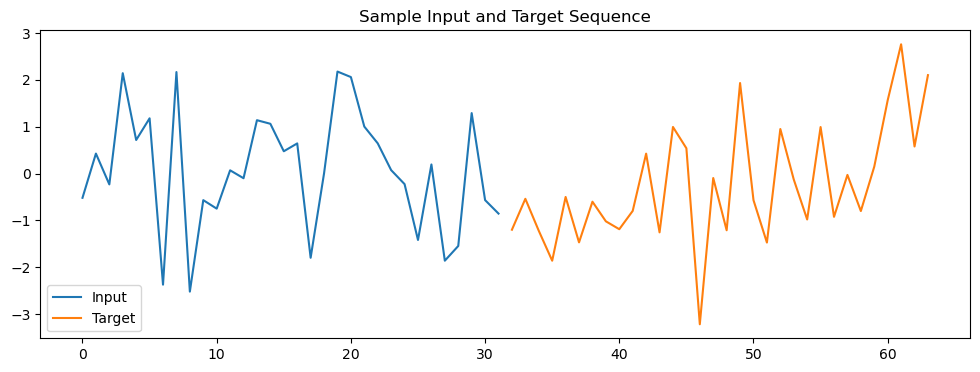

In [6]:
# Get input dimensions from first batch
for batch in train_loader:
    inputs, targets = batch
    input_dim = inputs.shape[-1]
    output_dim = targets.shape[-1]
    seq_len = inputs.shape[1]
    pred_len = targets.shape[1]
    break

print(f"Input dimension: {input_dim}")
print(f"Output dimension: {output_dim}")
print(f"Sequence length: {seq_len}")
print(f"Prediction length: {pred_len}")

# Visualize a sample from the dataset
plt.figure(figsize=(12, 4))
plt.plot(inputs[0, :, 0].numpy(), label='Input')
plt.plot(range(seq_len, seq_len + pred_len), targets[0, :, 0].numpy(), label='Target')
plt.title('Sample Input and Target Sequence')
plt.legend()
plt.show()

### 4. Define Worker Configurations

We'll create a pool of workers with different architectures:
- Two LSTM workers with different hidden dimensions
- One Transformer worker"

In [8]:
# Define worker configurations
worker_configs = [
    # LSTM Workers
    {
        'model_name': 'lstm',
        'input_dim': input_dim,
        'hidden_dim': 256,
        'num_layers': 2,
        'output_dim': output_dim,
        'dropout': 0.1
    },
    {
        'model_name': 'lstm',
        'input_dim': input_dim,
        'hidden_dim': 64,
        'num_layers': 2,
        'output_dim': output_dim,
        'dropout': 0.15
    },
    # Transformer Worker
    {
        'model_name': 'transformer',
        'input_dim': input_dim,
        'output_dim': output_dim,
        'seq_len': seq_len,
        'pred_len': pred_len,
        'd_model': 128,
        'n_heads': 4,
        'd_ff': 256,
        'num_layers': 2,
        'dropout': 0.1
    }
]

In [10]:
print("Worker Configurations:")
for i, config in enumerate(worker_configs):
    print(f"\nWorker {i}:")
    for key, value in config.items():
        print(f"  {key}: {value}")

Worker Configurations:

Worker 0:
  model_name: lstm
  input_dim: 7
  hidden_dim: 256
  num_layers: 2
  output_dim: 1
  dropout: 0.1

Worker 1:
  model_name: lstm
  input_dim: 7
  hidden_dim: 64
  num_layers: 2
  output_dim: 1
  dropout: 0.15

Worker 2:
  model_name: transformer
  input_dim: 7
  output_dim: 1
  seq_len: 32
  pred_len: 32
  d_model: 128
  n_heads: 4
  d_ff: 256
  num_layers: 2
  dropout: 0.1


### 5. Create Models

Create the worker models and the manager model that will coordinate between them.

In [11]:
 # Create worker models
worker_models = cap.catp.create_worker_pool(worker_configs, cap.catp.available_models())

# Create manager model
manager_model = cap.catp.ManagerModel(
    input_dim=input_dim,
    worker_count=len(worker_models),
    d_model=256,
    n_heads=4,
    d_ff=1024,
    num_layers=2,
    dropout=0.2
)

print(f"Created {len(worker_models)} worker models and 1 manager model")


Created 3 worker models and 1 manager model


### 6. Initialize Trainer

Create the CATP trainer with default optimizers and custom learning rates.

In [12]:
# Create trainer with default optimizers
trainer = cap.catp_trainer.CATPTrainer(
    manager_model=manager_model,
    worker_models=worker_models,
    criterion=nn.MSELoss(),
    device=device,
    manager_lr=0.005,  # Manager learning rate
    worker_lr=0.001    # Worker learning rate
)

### 7. Train the Model

Train the model with early stopping and metric plotting enabled.


Epoch 1/15
Current learning rates - Manager: 0.005000, Worker: 0.001000
  Batch 0: Worker Loss = 0.9935, Manager Loss = 4.1044
  Batch 10: Worker Loss = 0.9365, Manager Loss = 3.4379
  Batch 20: Worker Loss = 0.9236, Manager Loss = 3.1021
  Batch 30: Worker Loss = 0.9110, Manager Loss = 3.0396
  Batch 40: Worker Loss = 0.9087, Manager Loss = 3.0011
Validation Loss: 0.8804
Saved checkpoint with validation loss: 0.8804

Epoch 2/15
Current learning rates - Manager: 0.004945, Worker: 0.000989
  Batch 0: Worker Loss = 0.9081, Manager Loss = 3.0977
  Batch 10: Worker Loss = 0.9103, Manager Loss = 3.0886
  Batch 20: Worker Loss = 0.9067, Manager Loss = 3.0895
  Batch 30: Worker Loss = 0.8864, Manager Loss = 3.0841
  Batch 40: Worker Loss = 0.8872, Manager Loss = 3.0828
Validation Loss: 0.8762
Saved checkpoint with validation loss: 0.8762

Epoch 3/15
Current learning rates - Manager: 0.004732, Worker: 0.000947
  Batch 0: Worker Loss = 0.8404, Manager Loss = 3.1775
  Batch 10: Worker Loss = 0.

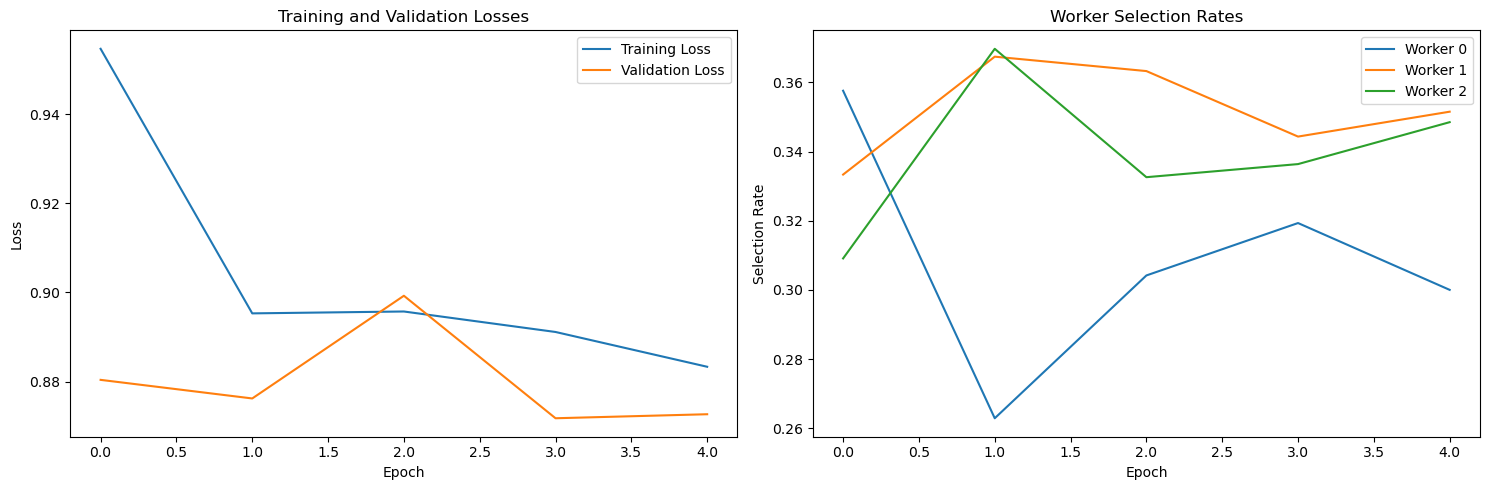


Epoch 6/15
Current learning rates - Manager: 0.002683, Worker: 0.000540
  Batch 0: Worker Loss = 0.9317, Manager Loss = 3.2752
  Batch 10: Worker Loss = 0.8570, Manager Loss = 3.2753
  Batch 20: Worker Loss = 0.8161, Manager Loss = 3.2752
  Batch 30: Worker Loss = 0.9369, Manager Loss = 3.2752
  Batch 40: Worker Loss = 0.8473, Manager Loss = 3.2752
Validation Loss: 0.8725

Epoch 7/15
Current learning rates - Manager: 0.001760, Worker: 0.000357
  Batch 0: Worker Loss = 0.8412, Manager Loss = 3.2752
  Batch 10: Worker Loss = 0.8761, Manager Loss = 3.2752
  Batch 20: Worker Loss = 0.8931, Manager Loss = 3.2752
  Batch 30: Worker Loss = 0.9778, Manager Loss = 3.2752
  Batch 40: Worker Loss = 0.8690, Manager Loss = 3.2752
Validation Loss: 0.8714
Saved checkpoint with validation loss: 0.8714

Epoch 8/15
Current learning rates - Manager: 0.000976, Worker: 0.000202
  Batch 0: Worker Loss = 0.8735, Manager Loss = 3.2752
  Batch 10: Worker Loss = 0.9524, Manager Loss = 3.2752
  Batch 20: Worker

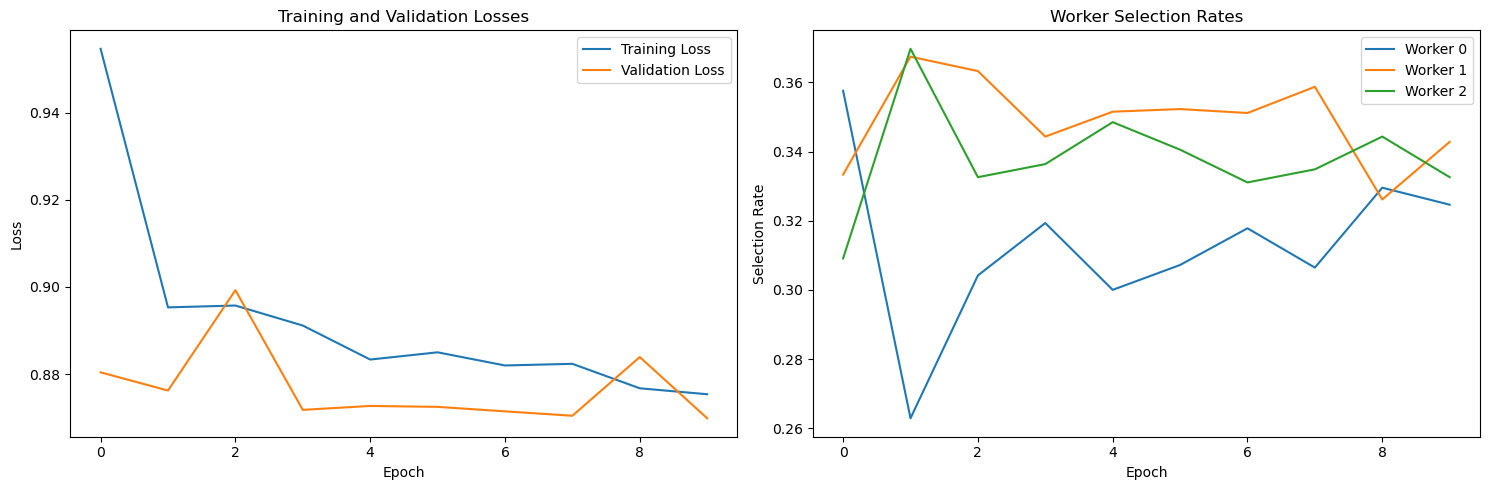


Epoch 11/15
Current learning rates - Manager: 0.000047, Worker: 0.000017
  Batch 0: Worker Loss = 0.8757, Manager Loss = 3.2752
  Batch 10: Worker Loss = 0.9026, Manager Loss = 3.2752
  Batch 20: Worker Loss = 0.8654, Manager Loss = 3.2752
  Batch 30: Worker Loss = 0.8398, Manager Loss = 3.2752
  Batch 40: Worker Loss = 0.8300, Manager Loss = 3.2752
Validation Loss: 0.8696
Saved checkpoint with validation loss: 0.8696

Epoch 12/15
Current learning rates - Manager: 0.000016, Worker: 0.000011
  Batch 0: Worker Loss = 0.8656, Manager Loss = 3.2752
  Batch 10: Worker Loss = 0.9091, Manager Loss = 3.2752
  Batch 20: Worker Loss = 0.9465, Manager Loss = 3.2752
  Batch 30: Worker Loss = 0.8505, Manager Loss = 3.2752
  Batch 40: Worker Loss = 0.8793, Manager Loss = 3.2752
Validation Loss: 0.8696
Saved checkpoint with validation loss: 0.8696

Epoch 13/15
Current learning rates - Manager: 0.000011, Worker: 0.000010
  Batch 0: Worker Loss = 0.8382, Manager Loss = 3.2752
  Batch 10: Worker Loss =

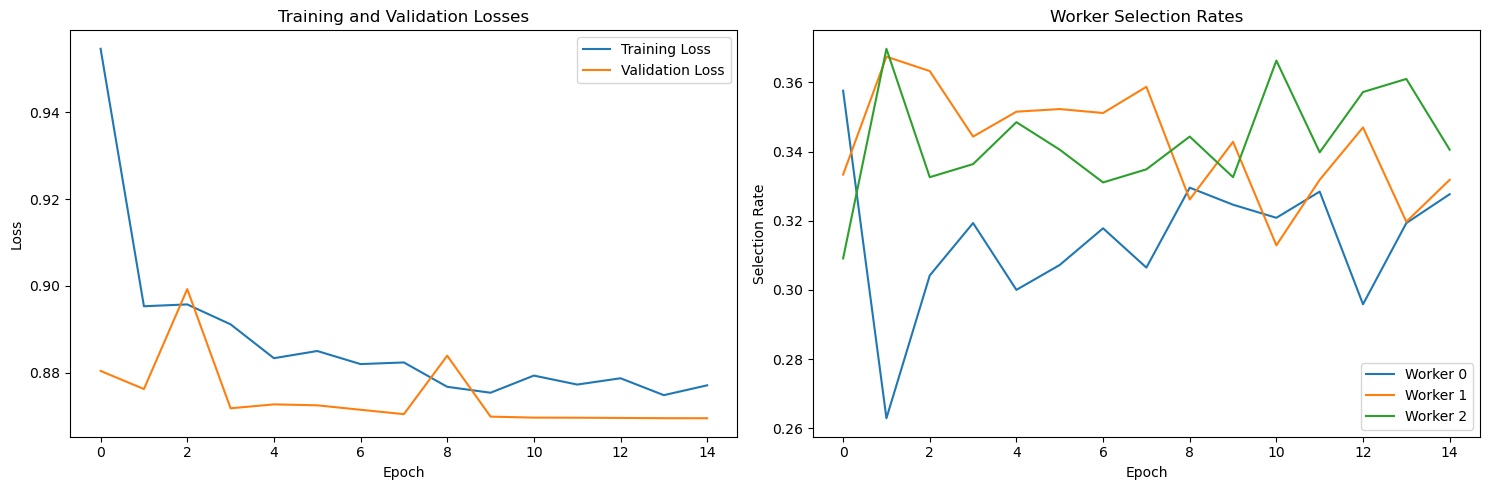

In [13]:
# Train the model
history = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=15,
    checkpoint_dir='checkpoints/cap',
    early_stopping_patience=5,  # Stop if no improvement for 5 epochs
    plot_metrics=True           # Show training plots
)